In [1]:
#!pip install tensorflow
#!pip install keras

import glob
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Bidirectional, Concatenate, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
import nltk

## Data Loading

####Enable access to google drive through google colab. This line can be ignored if data is downloaded locally.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Update the following line with the location of downloaded Flickr8 dataset. If you do not have the dataset downloaded you can find it at: https://www.kaggle.com/datasets/sayanf/flickr8k

In [3]:
data_path = '/content/drive/My Drive/Content/'

####Load the file containing image file names and associated caption.

In [4]:
token = data_path + 'Flickr8k_text/Flickr8k.token.txt'

In [5]:
captions = open(token, 'r').read().strip().split('\n')

####Create a dictionary containing they key-value relationship between image file names and captions

In [6]:
img_caption_dict = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in img_caption_dict:
        img_caption_dict[row[0]].append(row[1])
    else:
        img_caption_dict[row[0]] = [row[1]]

In [7]:
img_caption_dict['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

####Load all the image files.

In [8]:
images_path = data_path + 'Flickr8k_Dataset//'
images = glob.glob(images_path + '*.jpg')
len(images)

8101

####Helper function created for seperating file names from captions.

In [9]:
def split_data(l):
    temp = []
    for i in images:
        filename = i.split('/')[-1]
        if filename in l:
            temp.append(i)
    return temp

####Seperate the training images from the entire image dataset.

In [10]:
train_images_file = data_path + 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_image_names = set(open(train_images_file, 'r').read().strip().split('\n'))
train_images = split_data(train_image_names)
len(train_images)

6000

####Seperate the validation images from the entire image dataset.

In [ ]:
val_images_file = data_path + 'Flickr8k_text/Flickr_8k.devImages.txt'
val_image_names = set(open(val_images_file, 'r').read().strip().split('\n'))
val_images = split_data(val_image_names)
len(val_images)


####Seperate the testing images from the entire dataset.

In [ ]:
test_images_file = data_path + 'Flickr8k_text/Flickr_8k.testImages.txt'
test_image_names = set(open(test_images_file, 'r').read().strip().split('\n'))
test_images = split_data(test_image_names)
len(test_images)

##Image Preprocessing

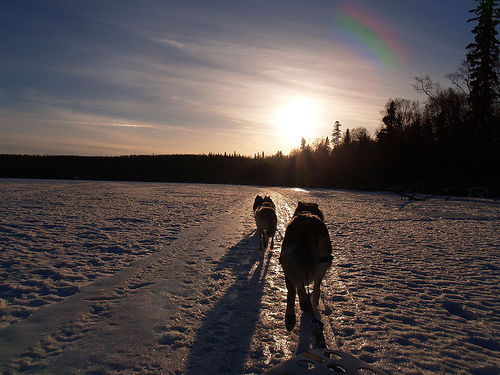

In [13]:
Image.open(train_images[0])

####Helper function used to preprocess image data as input for the CNN.

In [14]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

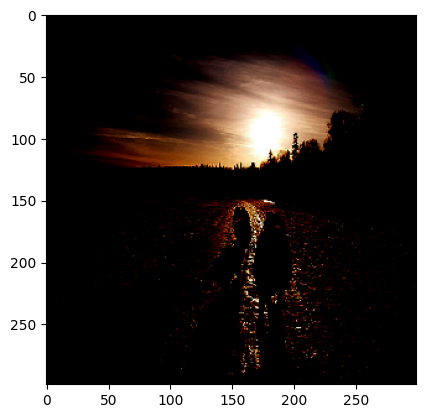

In [15]:
plt.imshow(np.squeeze(preprocess(train_images[0])))

####InceptionV3 is a widely used CNN for image classification. We are implementing this model by ignoring the final layer which applies an activation function to perform the classification. Using the output from the final hidden layer we can extract the feature vector of the image.

In [ ]:
model = InceptionV3(weights='imagenet')
new_input = model.input
hidden_layer = model.layers[-2].output
model_new = Model(new_input, hidden_layer)

In [17]:
output = model_new.predict(preprocess(train_images[0]))
output.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


(1, 2048)

####Helper method which preprocesses an image, passes it through the InceptionV3 CNN, and returns the feature vector as a 1D array.

In [18]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

####Create dictionary storing a mapping of each training image name to its feature vector.

In [ ]:
encoding_train = {}
for img in tqdm(train_images):
    encoding_train[img[len(images_path):]] = encode(img)

####Save the encoded features for training images to "encoded_images_inceptionV3.p".

In [20]:
with open(data_path + "encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [21]:
encoding_train = pickle.load(open(data_path + 'encoded_images_inceptionV3.p', 'rb'))
encoding_train[train_images[0][len(images_path):]].shape

(2048,)

####Create dictionary storing a mapping of each training image name to its feature vector.

In [ ]:
encoding_test = {}
for img in tqdm(test_images):
    encoding_test[img[len(images_path):]] = encode(img)

####Save the encoded features for training images to "encoded_images_test_inceptionV3.p".

In [23]:
with open(data_path + "encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [24]:
encoding_test = pickle.load(open(data_path + 'encoded_images_test_inceptionV3.p', 'rb'))
encoding_test[test_images[0][len(images_path):]].shape

(2048,)

####Create a dictionary containing they key-value relationship between training image file names and captions

In [25]:
train_dict = {}
for i in train_images:
    filename = i.split('/')[-1]
    if filename in img_caption_dict:
        train_dict[i] = img_caption_dict[filename]


In [26]:
len(train_dict)

6000

####Create a dictionary containing they key-value relationship between validation image file names and captions

In [27]:
val_dict = {}
for i in val_images:
    filename = i.split('/')[-1]
    if filename in img_caption_dict:
        val_dict[i] = img_caption_dict[filename]


In [28]:
len(val_dict)

1000

####Create a dictionary containing they key-value relationship between testing image file names and captions

In [29]:
test_d = {}
for i in test_images:
    filename = i.split('/')[-1]
    if filename in img_caption_dict:
        test_d[i] = img_caption_dict[filename]


In [30]:
len(test_d)

1000

##Caption Preprocessing

####Get the set of unique words from all training captions.

In [31]:
# Get all the captions from the training dictionary
captions = []
for key, val in train_dict.items():
    for i in val:
        captions.append('<start> ' + i + ' <end>')

# Get all the words from the captions
words = [i.split() for i in captions]

# Get the unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

####Save the unique words to "unique.p".

In [32]:
with open(data_path + "unique.p", "wb") as pickle_d:
     pickle.dump(unique, pickle_d)

In [33]:
unique = pickle.load(open(data_path + 'unique.p', 'rb'))

In [34]:
vocab_size = len(unique)
vocab_size

8256

####Create maps of each word to its index and each index to is word.

In [ ]:
word_idx_dict = {val:index for index, val in enumerate(unique)}
idx_word_dict = {index:val for index, val in enumerate(unique)}

Calculating the maximum length among all the captions.

In [36]:
max_len = 0
for c in captions:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

####Write the captions to the training text file with the 'start' and 'end' attatched.

In [37]:
f = open(data_path + 'flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [38]:
for key, val in train_dict.items():
    for i in val:
        f.write(key[len(images_path):] + "\t" + "<start> " + i +" <end>" + "\n")
f.close()

In [39]:
df = pd.read_csv(data_path + 'flickr8k_training_dataset.txt', delimiter='\t')
len(df)

30000

In [40]:
c = [i for i in df['captions']]
imgs = [i for i in df['image_id']]
a = c[-1]
a, imgs[-1]

('<start> Young girls jump on an outdoor trampoline . <end>',
 '43940240_a54a3c7989.jpg')

In [41]:
samples_per_epoch = 0
for ca in captions:
    samples_per_epoch += len(ca.split())-1
samples_per_epoch

383454

## Generator

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word
to predict the next word.
So, the image will be used at every iteration for the entire caption.
This is how we will generate the caption for an image. Hence, we need to create
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [42]:
def data_generator(batch_size=32):
    partial_caps = []
    next_words = []
    images = []

    df = pd.read_csv('/content/drive/MyDrive/Content/flickr8k_training_dataset.txt', delimiter='\t')
    df = df.sample(frac=1)
    iter = df.iterrows()
    c = []
    imgs = []

    for i in range(df.shape[0]):
        x = next(iter)
        c.append(x[1][1])
        imgs.append(x[1][0])

    count = 0
    while True:
        for j, text in enumerate(c):
            current_image = encoding_train[imgs[j]]
            for i in range(len(text.split()) - 1):
                count += 1

                partial = [word_idx_dict[txt] for txt in text.split()[:i+1]]
                partial_caps.append(partial)

                # Initializing with zeros to create a one-hot encoding matrix
                n = np.zeros(vocab_size)
                n[word_idx_dict[text.split()[i+1]]] = 1
                next_words.append(n)

                images.append(current_image)

                if count >= batch_size:
                    next_words = np.asarray(next_words)
                    images = np.asarray(images)
                    partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')

                    # Convert to tensors
                    images_tensor = tf.convert_to_tensor(images)
                    partial_caps_tensor = tf.convert_to_tensor(partial_caps)
                    next_words_tensor = tf.convert_to_tensor(next_words)

                    # Yield the tensors as a tuple
                    yield (images_tensor, partial_caps_tensor), next_words_tensor

                    # Reset for next batch
                    partial_caps = []
                    next_words = []
                    images = []
                    count = 0

## Model Creation

In [43]:
# Image model: Process the image vector
embedding_size = 300
image_input = Input(shape=(2048,))
image_model = Dense(embedding_size, activation='relu')(image_input)
image_model = RepeatVector(max_len)(image_model)

# Caption model: Processes the caption
caption_input = Input(shape=(max_len,))
caption_model = Embedding(vocab_size, embedding_size, input_length=max_len)(caption_input)

# Use return_sequences = True since we are trying to use the previous word to predict the next word.
caption_model = LSTM(256, return_sequences=True)(caption_model)
caption_model = TimeDistributed(Dense(300))(caption_model)

# Merge the models
merged = Concatenate(axis=1)([image_model, caption_model])

# Final model with Bidirectional LSTM and Dense layer
final_output = Bidirectional(LSTM(256, return_sequences=False))(merged)
final_output = Dense(vocab_size)(final_output)
final_output = Activation('softmax')(final_output)

# Create the model
final_model = Model(inputs=[image_input, caption_input], outputs=final_output)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [44]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [45]:
final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 300)        │      2,476,800 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 300)            │        614,700 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 40, 256)        │        570,368 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 40, 300)        │              0 │ dense[0][0]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 40, 300)        │         77,100 │ lstm[0][0]             │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 80, 300)        │              0 │ repeat_vector[0][0],   │
│ (Concatenate)             │                        │                │ time_distributed[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512)            │      1,140,736 │ concatenate_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8256)           │      4,235,328 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 8256)           │              0 │ dense_2[0][0]          │
│ (Activation)              │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,115,032 (34.77 MB)

 Trainable params: 9,115,032 (34.77 MB)

 Non-trainable params: 0 (0.00 B)

##Model Training.

In [46]:

final_model.fit(
    data_generator(batch_size=128),
    steps_per_epoch=samples_per_epoch,
    epochs=1,
    verbose=2
)


<ipython-input-42-bf42e472dab9>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c.append(x[1][1])
<ipython-input-42-bf42e472dab9>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imgs.append(x[1][0])


383454/383454 - 8404s - 22ms/step - accuracy: 0.4916 - loss: 2.5836


In [47]:
final_model.save_weights(data_path + 'time_inceptionV3_1.5987_loss.weights.h5')

In [48]:
final_model.load_weights(data_path + 'time_inceptionV3_1.5987_loss.weights.h5')

In [49]:
final_model.fit(
    data_generator(batch_size=128),
    steps_per_epoch=samples_per_epoch,
    epochs=1,
    verbose=2
)

<ipython-input-42-bf42e472dab9>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c.append(x[1][1])
<ipython-input-42-bf42e472dab9>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imgs.append(x[1][0])


383454/383454 - 8414s - 22ms/step - accuracy: 0.4743 - loss: 2.8024


In [50]:
final_model.save_weights(data_path + 'time_inceptionV3_1.5987_loss.weights.h5')

In [51]:
final_model.load_weights(data_path + 'time_inceptionV3_1.5987_loss.weights.h5')

In [130]:
final_model.fit(
    data_generator(batch_size=128),
    steps_per_epoch=samples_per_epoch,
    epochs=1,
    verbose=2
)

<ipython-input-42-bf42e472dab9>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c.append(x[1][1])
<ipython-input-42-bf42e472dab9>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imgs.append(x[1][0])


383454/383454 - 8419s - 22ms/step - accuracy: 0.4667 - loss: 3.0662


In [131]:
final_model.save_weights(data_path + 'time_inceptionV3_1.5987_loss.weights.h5')

In [ ]:
final_model.load_weights(data_path + 'time_inceptionV3_1.5987_loss.weights.h5')

In [ ]:
final_model.fit(
    data_generator(batch_size=128),
    steps_per_epoch=samples_per_epoch,
    epochs=1,
    verbose=2
)

In [ ]:
final_model.save_weights(data_path + 'time_inceptionV3_1.5987_loss.weights.h5')

In [ ]:
final_model.load_weights(data_path + 'time_inceptionV3_1.5987_loss.weights.h5')

## Model Prediction

In [53]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_idx_dict[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images_path):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)], verbose=0)
        word_pred = idx_word_dict[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

In [54]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_idx_dict["<start>"]]

    start_word = [[start, 0.0]]

    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images_path):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)], verbose=0)

            word_preds = np.argsort(preds[0])[-beam_index:]

            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [idx_word_dict[i] for i in start_word]

    final_caption = []

    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

Normal Max search: A basketball player attempts to do a shot .
Beam Search, k=3: A basketball player dribbles a basketball .
Beam Search, k=5: A basketball player dribbles a ball .
Beam Search, k=7: A basketball player tries to make a hoop .


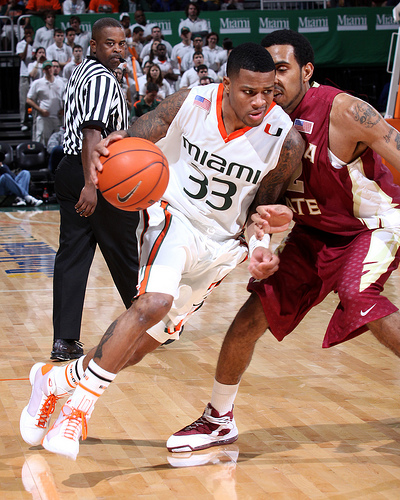

In [118]:
test_image1 = test_images[52]
print ('Normal Max search:', predict_captions(test_image1))
print ('Beam Search, k=3:', beam_search_predictions(test_image1, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image1, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image1, beam_index=7))
Image.open(test_image1)

Normal Max search: A man in a striped shirt slides down a rail .
Beam Search, k=3: A man in a striped shirt slides down a railing .
Beam Search, k=5: A snowboarder slides down a rail .
Beam Search, k=7: A snowboarder slides down a rail .


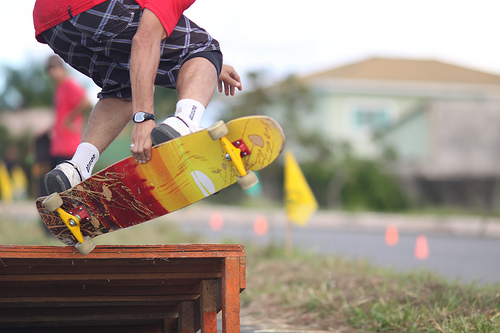

In [119]:
test_image2 = test_images[831]
print ('Normal Max search:', predict_captions(test_image2))
print ('Beam Search, k=3:', beam_search_predictions(test_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image2, beam_index=7))
Image.open(test_image2)

Normal Max search: A group of sled dogs pulling both sled .
Beam Search, k=3: A group of sled sled people are pulling sled .
Beam Search, k=5: A group of bicyclists pulling a sled in the snow .
Beam Search, k=7: A group of skiers pulling a sled .


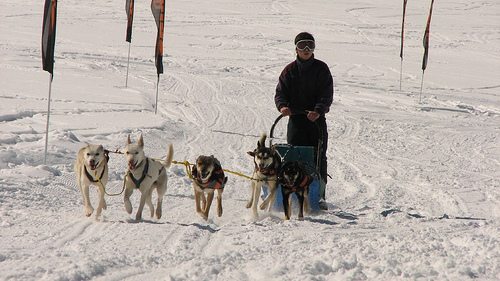

In [120]:
test_image3 = test_images[9]
print ('Normal Max search:', predict_captions(test_image3))
print ('Beam Search, k=3:', beam_search_predictions(test_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image3, beam_index=7))
Image.open(test_image3)

Normal Max search: A dog is biting a bat .
Beam Search, k=3: A brown dog in a harness is catching a Frisbee .
Beam Search, k=5: A brown dog biting a white dog .
Beam Search, k=7: A brown dog biting a brown dog .


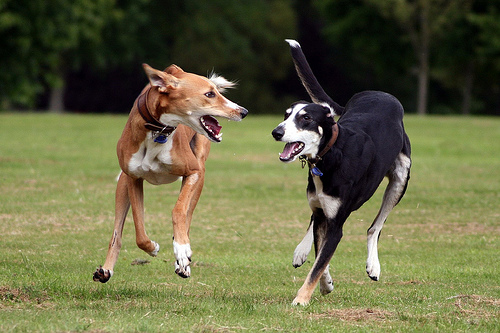

In [121]:
test_image4 = test_images[102]
print ('Normal Max search:', predict_captions(test_image4))
print ('Beam Search, k=3:', beam_search_predictions(test_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image4, beam_index=7))
Image.open(test_image4)

Normal Max search: A man in a wetsuit is fishing in a boat on the water .
Beam Search, k=3: Two people swim in the water .
Beam Search, k=5: The two people swim in the water .
Beam Search, k=7: The two people swim in the water .


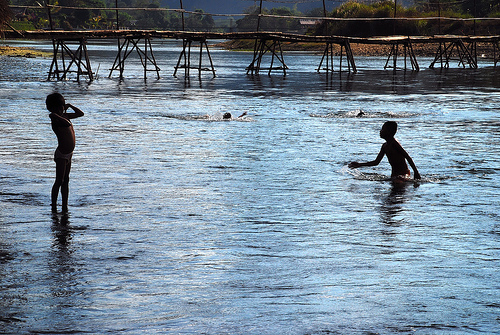

In [122]:
test_image5 = test_images[122]
print ('Normal Max search:', predict_captions(test_image5))
print ('Beam Search, k=3:', beam_search_predictions(test_image5, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image5, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image5, beam_index=7))
Image.open(test_image5)

Normal Max search: A woman in a red coat is fishing in a puddle in the lake .
Beam Search, k=3: A little girl in a red bathing suit climbs a rock .
Beam Search, k=5: A woman in a bathing suit stands on a rock in a lake .
Beam Search, k=7: A little girl in a bathing suit swings on a body of water .


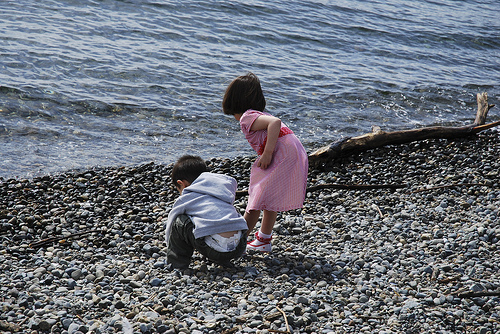

In [123]:
test_image6 = test_images[935]
print ('Normal Max search:', predict_captions(test_image6))
print ('Beam Search, k=3:', beam_search_predictions(test_image6, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image6, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image6, beam_index=7))
Image.open(test_image6)

Normal Max search: A group of people gather on a stage .
Beam Search, k=3: A group of adults gather for a train .
Beam Search, k=5: A group of people gather on a stage .
Beam Search, k=7: A group of people gather on a stage .


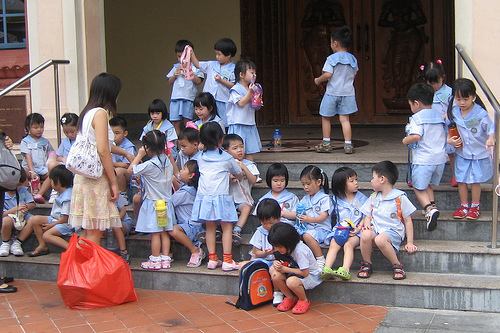

In [124]:
test_image7 = test_images[325]
print ('Normal Max search:', predict_captions(test_image7))
print ('Beam Search, k=3:', beam_search_predictions(test_image7, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image7, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image7, beam_index=7))
Image.open(test_image7)

Normal Max search: A snowboarder in a red coat skis down a snowy hill .
Beam Search, k=3: A snowboarder slides down a snow covered mountain .
Beam Search, k=5: A snowboarder slides down a snowy hill .
Beam Search, k=7: A snowboarder snowboarding .


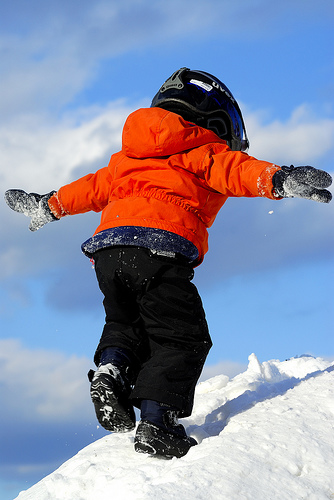

In [125]:
test_image8 = test_images[327]
print ('Normal Max search:', predict_captions(test_image8))
print ('Beam Search, k=3:', beam_search_predictions(test_image8, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image8, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image8, beam_index=7))
Image.open(test_image8)

Normal Max search: A bird flies through the air .
Beam Search, k=3: A bird flies through the air .
Beam Search, k=5: A bird flies through the air towards the camera .
Beam Search, k=7: A swans on the water .


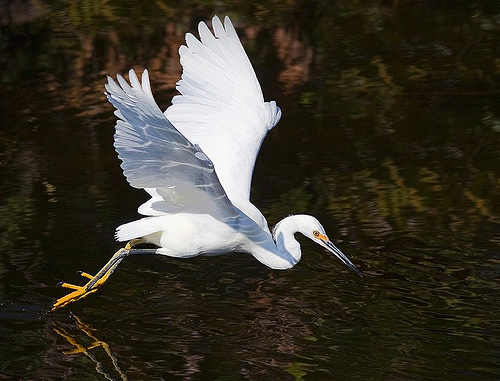

In [126]:
test_image9 = test_images[697]
print ('Normal Max search:', predict_captions(test_image9))
print ('Beam Search, k=3:', beam_search_predictions(test_image9, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image9, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image9, beam_index=7))
Image.open(test_image9)

Normal Max search: A brown dog biting a smaller dogs .
Beam Search, k=3: A brown dog biting a bird .
Beam Search, k=5: A brown dog chews on a stick .
Beam Search, k=7: A brown dog chews on a leash .


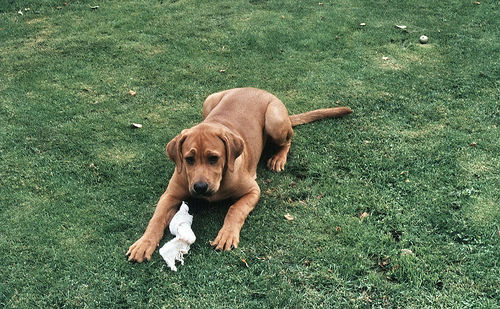

In [127]:
test_image10 = test_images[507]
print ('Normal Max search:', predict_captions(test_image10))
print ('Beam Search, k=3:', beam_search_predictions(test_image10, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image10, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image10, beam_index=7))
Image.open(test_image10)

Normal Max search: A dog is leaping into the water .
Beam Search, k=3: A brown dog splashes in the water .
Beam Search, k=5: A golden haired dog splashing in the water .
Beam Search, k=7: A golden haired dog splashing in the water .


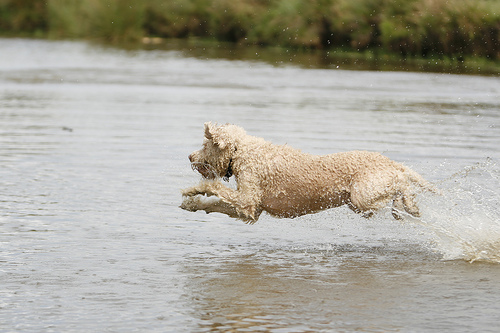

In [128]:
test_image11 = test_images[875]
print ('Normal Max search:', predict_captions(test_image11))
print ('Beam Search, k=3:', beam_search_predictions(test_image11, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image11, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image11, beam_index=7))
Image.open(test_image11)

Normal Max search: A little girl in a red dress is running through a field of grass .
Beam Search, k=3: A little girl in a red dress swings on a snowy field .
Beam Search, k=5: A little girl in a red dress swings on a snowy field .
Beam Search, k=7: A little girl in a red dress swings on a snowy field .


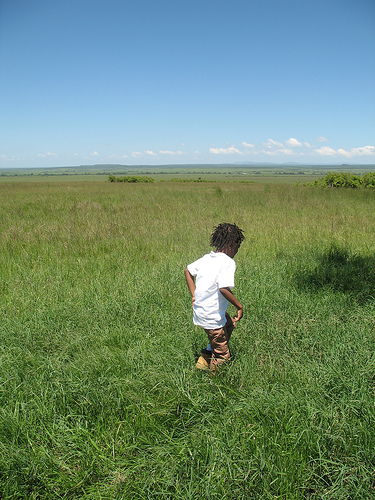

In [129]:
test_image12 = test_images[900]
print ('Normal Max search:', predict_captions(test_image12))
print ('Beam Search, k=3:', beam_search_predictions(test_image12, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(test_image12, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(test_image12, beam_index=7))
Image.open(test_image12)